# Getting started

Let's get started exploring the content of a [FEWS-API](https://publicwiki.deltares.nl/display/FEWSDOC/FEWS+PI+REST+Web+Service). 

We define our FEWS-API Python object with an url:

In [1]:
from fewspy import Api

api = Api(
    url=r"https://www.hydrobase.nl/fews/nzv/FewsWebServices/rest/fewspiservice/v1/",
    ssl_verify=False,
)

First we request the filters of our FEWS-API. It will return a dictionary in the same structure as the FEWS-API [JSON response](https://publicwiki.deltares.nl/display/FEWSDOC/FEWS+PI+REST+Web+Service#FEWSPIRESTWebService-GETfilters)

In [2]:
api.get_filters()

[{'id': 'webservices',
  'name': 'WebServices',
  'child': [{'id': 'WDB',
    'name': 'WAM Dashboard',
    'child': [{'id': 'WDB_OW',
      'name': 'Oppervlaktewater',
      'child': [{'id': 'WDB_OW_KGM', 'name': 'Gemaal'},
       {'id': 'WDB_OW_KST', 'name': 'Stuw'},
       {'id': 'WDB_OW_INL', 'name': 'Inlaat'},
       {'id': 'WDB_OW_KSL', 'name': 'Sluis'},
       {'id': 'WDB_OW_MPN', 'name': 'Meetpunt (hydrologisch)'}]},
     {'id': 'WDB_GW',
      'name': 'Grondwater',
      'child': [{'id': 'WDB_GW_GMW', 'name': 'Peilbuis'}]},
     {'id': 'WDB_FC',
      'name': 'Fysisch-Chemisch',
      'child': [{'id': 'WDB_FC_PARA_ALGEMEEN', 'name': 'Algemene stoffen'},
       {'id': 'WDB_FC_PARA_BASISFC',
        'name': 'Basis fysisch-chemische stoffen'},
       {'id': 'WDB_FC_MMN_KRW_TOESTAND',
        'name': 'KRW toestandsbepaling meetpunten'},
       {'id': 'WDB_FC_PARA_KRW_PRIORITAIR',
        'name': 'KRW prioritaire stoffen (2013)'},
       {'id': 'WDB_FC_PARA_SPECIFIEK',
        'name

Now we'll request the locations of an existing filter. In this example for filter_id `WDB_OW_KGM` (pumps/gemalen). The response JSON is parsed to a GeoPandas GeoDataFrame we can explore.

In [3]:
locations = api.get_locations(filter_id="WDB_OW_KGM")
locations.explore()

Let's see what we have for a known location id.

In [4]:
locations.loc["NL34.HL.KGM311.HWZ1"] 

short_name               KGM311 - HWZ1 (BE)
lat                      53.172517660606175
lon                       6.579783481401717
x                                  234743.0
y                                  576863.0
z                                       0.0
parent_location_id           NL34.HL.KGM311
geometry              POINT (234743 576863)
Name: NL34.HL.KGM311.HWZ1, dtype: object

Let's see what time-series are available for this location, using the FEWS API [get time series](https://publicwiki.deltares.nl/display/FEWSDOC/FEWS+PI+REST+Web+Service#FEWSPIRESTWebService-GETtimeseries). Dirty trick is to set `end_time` equal to `start_time` as the FEWS-API will give faster response. We set `only headers` to omit the transfer of actual time series data.

In [5]:
from datetime import datetime

time_series_headers = api.get_time_series(
    filter_id="WDB_OW_KGM",
    location_ids=["NL34.HL.KGM156.KWK"],
    start_time=datetime(2023,1,1),
    end_time=datetime(2023,1,1),
    only_headers=True)

print(f"We have {len(time_series_headers)} time series\n")

print("If we print the header of the first time series pretty we get:\n")
time_series_headers.time_series[0].header.__dict__

We have 1 time series

If we print the header of the first time series pretty we get:



{'type': 'instantaneous',
 'module_instance_id': 'Productie',
 'location_id': 'NL34.HL.KGM156.KWK',
 'parameter_id': 'Q [m3/s] [NVT] [OW]',
 'time_step': {'unit': 'nonequidistant'},
 'start_date': datetime.datetime(2023, 1, 1, 0, 0),
 'end_date': datetime.datetime(2023, 1, 1, 0, 0),
 'miss_val': -999.0,
 'lat': 53.3514399934006,
 'lon': 6.449843832251746,
 'x': 225761.0,
 'y': 596638.0,
 'units': 'm3/s',
 'station_name': 'KGM156 - KWK',
 'z': 0.0,
 'qualifier_id': ['productie']}

Now we have all relevant input for requesting the full time series. We request the full series again and now plot the events. 

Notes:
1. TimeSeriesSets in FEWSPY object follow the structure of a FEWS PI-JSON as found in the FEWS API [get timeseries documentation](https://publicwiki.deltares.nl/display/FEWSDOC/FEWS+PI+REST+Web+Service#FEWSPIRESTWebService-GETtimeseries)
2. The key-words are all `snake_case` (e.g. location_ids), following Python-conventions whereas FEWS-API conforms to `camelCasing` (locationIds in the same example). But that is all just style and convention, it all means the same!

<AxesSubplot: title={'center': 'NL34.HL.KGM156.KWK'}, xlabel='datetime', ylabel='Q [m3/s] [NVT] [OW]'>

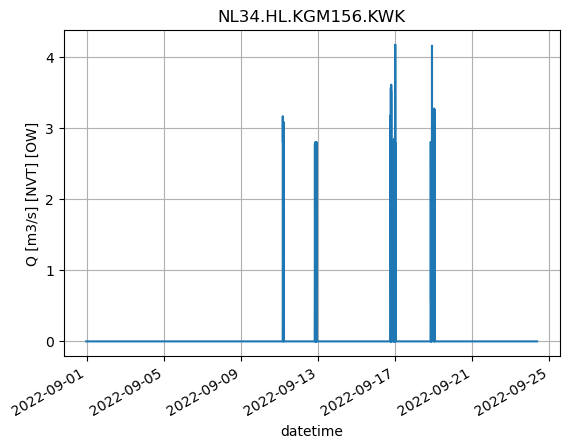

In [6]:
time_series_set = api.get_time_series(
    filter_id="WDB_OW",
    location_ids=["NL34.HL.KGM156.KWK"],
    parameter_ids=["Q [m3/s] [NVT] [OW]"],
    qualifier_ids=["productie"],
    start_time=datetime(2022,9,1),
    end_time=datetime(2023,1,1))

time_series = time_series_set.time_series[0]
time_series.events.value.plot(
    ylabel=time_series.header.parameter_id,
    title=time_series.header.location_id,
    grid=True)